# Evaluate SASRec Baseline

In [1]:
import shutil
import sys
from dataclasses import dataclass, field
from pathlib import Path
from typing import Dict, List, Tuple

import matplotlib.pyplot as plt
import numpy as np
import polars as pl
import torch
from tqdm.auto import tqdm

import wandb

# Add parent directory to path for imports
sys.path.append(str(Path.cwd().parent))

from src.device_manager import DeviceManager
from src.logger import setup_logger

# Import model classes from training script
from src.train_sasrec import SASRec, SASRecConfig

# Setup
logger = setup_logger("evaluate-sasrec", log_to_file=False)
device_manager = DeviceManager(logger)
device = device_manager.device

20:23:41 - Using device: mps


## Configuration

In [2]:
@dataclass
class EvalConfig:
    """Configuration for evaluation."""

    # Data
    dataset: str = "Video_Games"
    data_dir: Path = field(default_factory=lambda: Path("../data"))
    sequences_path: Path = field(
        default_factory=lambda: Path("../data/output/Video_Games_sequences_with_semantic_ids_val.parquet")
    )

    # Model
    models_dir: Path = field(default_factory=lambda: Path("../models/sasrec"))
    artifact_path: str = "eugeneyan/sasrec-experiments/sasrec-best-Video_Games:v85"

    # Evaluation
    val_fraction: float = 1  # Fraction of data to use for validation
    batch_size: int = 256
    num_negative_samples: int = 1000  # Number of negative samples for evaluation
    max_seq_length: int = 50
    seed: int = 42

    def __post_init__(self):
        """Create directories if needed."""
        self.models_dir.mkdir(parents=True, exist_ok=True)


config = EvalConfig()
logger.info(f"Configuration: {config}")

20:23:41 - Configuration: EvalConfig(dataset='Video_Games', data_dir=PosixPath('../data'), sequences_path=PosixPath('../data/output/Video_Games_sequences_with_semantic_ids_val.parquet'), models_dir=PosixPath('../models/sasrec'), artifact_path='eugeneyan/sasrec-experiments/sasrec-best-Video_Games:v85', val_fraction=1, batch_size=256, num_negative_samples=1000, max_seq_length=50, seed=42)


## Download Model from W&B

In [3]:
# Download model from W&B
logger.info(f"Downloading model from W&B: {config.artifact_path}")

version = config.artifact_path.split(":")[-1]
run = wandb.init(project="sasrec-evaluation", name=f"eval-sasrec-{version}")
artifact = run.use_artifact(config.artifact_path, type="model")
artifact_dir = artifact.download(config.models_dir)

# Find and rename the downloaded model file
downloaded_files = list(Path(artifact_dir).glob("*.pth"))
if downloaded_files:
    old_path = downloaded_files[0]
    new_path = config.models_dir / f"sasrec_{config.dataset.lower()}_{version}.pth"
    if old_path != new_path:
        shutil.move(str(old_path), str(new_path))
    model_path = new_path
    logger.info(f"Model downloaded to {model_path}")
else:
    raise FileNotFoundError(f"No .pth file found in {artifact_dir}")

wandb.finish()

20:23:41 - Downloading model from W&B: eugeneyan/sasrec-experiments/sasrec-best-Video_Games:v85


wandb: Currently logged in as: eugeneyan to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


wandb:   1 of 1 files downloaded.  


20:23:45 - Model downloaded to ../models/sasrec/sasrec_video_games_v85.pth


## Load Model from Checkpoint

In [4]:
def load_sasrec_model(model_path: str, device: str = None) -> Tuple[SASRec, SASRecConfig, dict, str]:
    """Load SASRec model from checkpoint with item mappings."""

    # Auto-detect device if not specified
    if device is None:
        if torch.cuda.is_available():
            device = "cuda"
        elif torch.backends.mps.is_available():
            device = "mps"
        else:
            device = "cpu"

    # Load checkpoint
    logger.info(f"Loading checkpoint from {model_path}")
    checkpoint = torch.load(model_path, map_location=device, weights_only=False)

    # Extract config from checkpoint
    if "config" in checkpoint:
        config_dict = checkpoint["config"]
        logger.info("Found config in checkpoint")

        # Create SASRecConfig from saved config
        sasrec_config = SASRecConfig()

        # Update config parameters if they exist in the saved config
        if isinstance(config_dict, dict):
            for key, value in config_dict.items():
                if hasattr(sasrec_config, key):
                    setattr(sasrec_config, key, value)
                    logger.info(f"  {key}: {value}")
    else:
        # Use default config
        logger.warning("No config found in checkpoint, using defaults")
        sasrec_config = SASRecConfig()

    # Get number of items from the embedding layer shape
    state_dict = checkpoint["model_state_dict"]

    # Handle compiled model state dict (keys might start with '_orig_mod.')
    if any(k.startswith("_orig_mod.") for k in state_dict.keys()):
        logger.info("Detected compiled model, removing '_orig_mod.' prefix")
        state_dict = {k.replace("_orig_mod.", ""): v for k, v in state_dict.items()}

    # Get item_num from embedding weight shape
    item_emb_weight = state_dict["item_emb.weight"]
    item_num = item_emb_weight.shape[0] - 1  # Subtract 1 for padding token
    logger.info(f"Detected {item_num} items from embedding layer")

    # Load item mappings if available
    item_mappings = {}
    if "item_to_id" in checkpoint and "id_to_item" in checkpoint:
        logger.info("Found item mappings in checkpoint")
        item_mappings["item_to_id"] = checkpoint["item_to_id"]
        item_mappings["id_to_item"] = checkpoint["id_to_item"]
        logger.info(f"  Loaded mappings for {len(item_mappings['item_to_id'])} items")
    else:
        logger.warning("No item mappings found in checkpoint - evaluation may use incorrect IDs!")

    # Create model instance
    model = SASRec(sasrec_config, item_num=item_num)

    # Load weights
    model.load_state_dict(state_dict)
    model = model.to(device)
    model.eval()

    # Log model info
    total_params = sum(p.numel() for p in model.parameters())
    logger.info(f"Model loaded successfully on {device}")
    logger.info(f"Total parameters: {total_params:,}")

    return model, sasrec_config, item_mappings, device, checkpoint


# Load the model and mappings
model, sasrec_config, item_mappings, device, checkpoint = load_sasrec_model(str(model_path), device=device)
logger.info(f"Model config: {sasrec_config}")

20:23:46 - Loading checkpoint from ../models/sasrec/sasrec_video_games_v85.pth
20:23:46 - No config found in checkpoint, using defaults
20:23:46 - Detected 14639 items from embedding layer
20:23:46 - Found item mappings in checkpoint
20:23:46 -   Loaded mappings for 14639 items
20:23:46 - Model loaded successfully on mps
20:23:46 - Total parameters: 993,984
20:23:46 - Model config: SASRecConfig(dataset='Video_Games', data_dir=PosixPath('data'), data_path=PosixPath('data/output/Video_Games_sequences_with_semantic_ids_train.parquet'), checkpoint_dir=PosixPath('checkpoints/sasrec'), max_seq_length=100, hidden_units=64, num_blocks=2, num_heads=1, dropout_rate=0.2, batch_size=1024, num_epochs=200, max_learning_rate=0.001, min_learning_rate=1e-05, scheduler_type='cosine', warmup_steps=100, warmup_start_lr=1e-08, steps_per_train_log=100, steps_per_val_log=500)


## Load and Prepare Data

In [5]:
# Load sequences data
logger.info(f"Loading data from {config.sequences_path}")
df = pl.read_parquet(config.sequences_path)
logger.info(f"Loaded {len(df)} sequences")
logger.info(f"Columns: {df.columns}")

# Extract sequences (item IDs, not semantic IDs)
users = df["user_id"].to_list()
sequences = df["sequence"].to_list()

# Filter sequences with at least 2 items (need one for input, one for target)
# AND truncate to max_seq_length if needed
valid_data = []
truncated_count = 0
for u, s in zip(users, sequences):
    if len(s) >= 2:
        if len(s) > config.max_seq_length:
            # Keep the most recent max_seq_length items
            s = s[-config.max_seq_length :]
            truncated_count += 1
        valid_data.append((u, s))

logger.info(f"Valid sequences (>= 2 items): {len(valid_data)}")
logger.info(f"Sequences truncated to max_seq_length ({config.max_seq_length}): {truncated_count}")

# Sample validation set
np.random.seed(config.seed)
n_val = int(len(valid_data) * config.val_fraction)
val_indices = np.random.choice(len(valid_data), size=n_val, replace=False)
val_data = [valid_data[i] for i in val_indices]
logger.info(f"Sampled {len(val_data)} sequences for validation")

# Log sequence length statistics after truncation
seq_lengths = [len(s) for _, s in val_data]
logger.info(
    f"Sequence length stats after truncation: min={min(seq_lengths)}, max={max(seq_lengths)}, avg={np.mean(seq_lengths):.1f}"
)

20:23:46 - Loading data from ../data/output/Video_Games_sequences_with_semantic_ids_val.parquet
20:23:46 - Loaded 7862 sequences
20:23:46 - Columns: ['user_id', 'sequence', 'sequence_length', 'semantic_id_sequence', 'semantic_id_sequence_length']
20:23:46 - Valid sequences (>= 2 items): 7862
20:23:46 - Sequences truncated to max_seq_length (50): 16
20:23:46 - Sampled 7862 sequences for validation
20:23:46 - Sequence length stats after truncation: min=3, max=50, avg=6.5


In [6]:
# Use item mappings from checkpoint if available, otherwise create new ones
if item_mappings and "item_to_id" in item_mappings and "id_to_item" in item_mappings:
    logger.info("Using item mappings from trained model")
    item_to_id = item_mappings["item_to_id"]
    id_to_item = item_mappings["id_to_item"]

    # Check which validation items are in vocabulary
    all_val_items = set()
    for _, seq in val_data:
        all_val_items.update(seq)

    in_vocab_items = set(item for item in all_val_items if item in item_to_id)
    oov_items = all_val_items - in_vocab_items

    logger.info(
        f"Validation items in training vocabulary: {len(in_vocab_items)}/{len(all_val_items)} ({len(in_vocab_items) / len(all_val_items) * 100:.1f}%)"
    )
    logger.info(f"Out-of-vocabulary items: {len(oov_items)} ({len(oov_items) / len(all_val_items) * 100:.1f}%)")

    # Create candidate pool from training vocabulary (only items that appear in validation)
    candidate_pool = list(set(item_to_id[item] for item in in_vocab_items))
    num_unique_items = len(in_vocab_items)
    max_item_id = max(item_to_id.values())
else:
    raise Exception("No item mappings found in checkpoint - evaluation may use incorrect IDs!")

logger.info(f"Unique items for evaluation: {num_unique_items}")
logger.info(f"Max item ID: {max_item_id}")

# Convert sequences to integer IDs, handling OOV items
val_data_ids = []
sequences_with_oov = 0
total_oov_items_in_sequences = 0

for user, seq in val_data:
    seq_ids = []
    has_oov = False
    for item in seq:
        if item in item_to_id:
            seq_ids.append(item_to_id[item])
        else:
            # Use padding ID (0) for OOV items
            seq_ids.append(0)
            has_oov = True
            total_oov_items_in_sequences += 1

    if has_oov:
        sequences_with_oov += 1

    # Only keep sequences with at least 2 valid (non-OOV) items
    if sum(1 for id in seq_ids if id != 0) >= 2:
        val_data_ids.append((user, seq_ids))

logger.info(f"Converted {len(val_data_ids)} sequences to integer IDs")
logger.info(
    f"Sequences containing OOV items: {sequences_with_oov}/{len(val_data)} ({sequences_with_oov / len(val_data) * 100:.1f}%)"
)
logger.info(f"Total OOV items in sequences: {total_oov_items_in_sequences}")
logger.info(f"Sequences kept after OOV filtering: {len(val_data_ids)}/{len(val_data)}")

20:23:46 - Using item mappings from trained model
20:23:46 - Validation items in training vocabulary: 10383/10396 (99.9%)
20:23:46 - Out-of-vocabulary items: 13 (0.1%)
20:23:46 - Unique items for evaluation: 10383
20:23:46 - Max item ID: 14639
20:23:46 - Converted 7862 sequences to integer IDs
20:23:46 - Sequences containing OOV items: 20/7862 (0.3%)
20:23:46 - Total OOV items in sequences: 20
20:23:46 - Sequences kept after OOV filtering: 7862/7862


## Evaluation Functions

In [7]:
def calculate_metrics(ranks: np.ndarray, k: int = 10) -> Dict[str, float]:
    """Calculate Hit@k and NDCG@k from ranks."""
    hit_at_k = np.mean(ranks <= k)

    # NDCG@k
    ndcg_at_k = 0.0
    for rank in ranks:
        if rank <= k:
            ndcg_at_k += 1 / np.log2(rank + 1)
    ndcg_at_k /= len(ranks)

    return {f"hit@{k}": hit_at_k, f"ndcg@{k}": ndcg_at_k}


def evaluate_model(
    model: SASRec,
    val_data: List[Tuple[str, List[int]]],
    candidate_pool: set,
    batch_size: int = 256,
    num_neg_samples: int = 100,
    device: str = "cpu",
    sasrec_config: SASRecConfig = None,
) -> Tuple[Dict[str, float], np.ndarray]:
    """
    Evaluate model on validation data by sampling from entire catalog.

    Args:
        model: Trained SASRec model
        val_data: List of (user, sequence) tuples with integer IDs
        candidate_pool: Set of all unique item IDs in the dataset
        batch_size: Batch size for evaluation
        num_neg_samples: Number of negative samples (total will be num_neg_samples + 1 with target)
        device: Device to run on
        sasrec_config: Model configuration

    Returns:
        Tuple of (metrics dict, ranks array)
    """
    model.eval()

    # Convert all items to list for sampling
    all_items_list = list(candidate_pool)
    logger.info(f"Sampling {num_neg_samples} negative samples from pool of {len(all_items_list)} items")

    all_ranks = []

    with torch.no_grad():
        for batch_start in tqdm(range(0, len(val_data), batch_size), desc="Evaluating"):
            batch = val_data[batch_start : batch_start + batch_size]

            batch_input_seqs = []
            batch_targets = []
            batch_candidates = []

            for user, seq in batch:
                # Use all but last item as input
                input_seq = seq[:-1]
                target = seq[-1]

                # Truncate if longer than max_seq_length
                if len(input_seq) > sasrec_config.max_seq_length:
                    input_seq = input_seq[-sasrec_config.max_seq_length :]

                batch_input_seqs.append(input_seq)
                batch_targets.append(target)

                # Sample items from entire catalog, excluding the target
                items_to_sample_from = [item for item in all_items_list if item != target]

                sampled_negatives = np.random.choice(
                    items_to_sample_from, size=min(num_neg_samples, len(items_to_sample_from)), replace=False
                )

                # Put target at position 0, then all sampled negatives
                candidates = [target] + list(sampled_negatives)
                batch_candidates.append(candidates)

            # Prepare input tensor
            max_len = max(len(s) for s in batch_input_seqs)
            input_tensor = torch.zeros((len(batch), max_len), dtype=torch.long)

            for i, seq in enumerate(batch_input_seqs):
                input_tensor[i, -len(seq) :] = torch.tensor(seq)

            input_tensor = input_tensor.to(device)

            # Prepare candidates tensor - all lists now have same length
            candidates_tensor = torch.tensor(batch_candidates, dtype=torch.long, device=device)

            # Get predictions
            scores = model.predict(input_tensor, candidates_tensor)

            # Find rank of target item (which is at position 0)
            _, indices = torch.sort(scores, dim=1, descending=True)
            ranks = (indices == 0).nonzero(as_tuple=True)[1].cpu().numpy() + 1  # 1-indexed
            all_ranks.extend(ranks)

    # Calculate metrics
    all_ranks = np.array(all_ranks)
    metrics = calculate_metrics(all_ranks, k=10)

    # Add additional statistics
    metrics["mean_rank"] = np.mean(all_ranks)
    metrics["median_rank"] = np.median(all_ranks)
    metrics["mrr"] = np.mean(1.0 / all_ranks)  # Mean Reciprocal Rank

    return metrics, all_ranks

## Run Evaluation

In [8]:
# Run evaluation
logger.info("Starting evaluation...")
metrics, ranks = evaluate_model(
    model=model,
    val_data=val_data_ids,
    candidate_pool=candidate_pool,
    batch_size=config.batch_size,
    num_neg_samples=config.num_negative_samples,
    device=device,
    sasrec_config=sasrec_config
)

20:23:46 - Starting evaluation...
20:23:46 - Sampling 1000 negative samples from pool of 10383 items


Evaluating:   0%|          | 0/31 [00:00<?, ?it/s]

In [9]:
# Calculate and display summary statistics
seq_lengths = [len(seq) for _, seq in val_data_ids]
# Calculate and display summary statistics
summary_stats = {
    "Dataset": config.dataset,
    "Model Path": str(model_path.name),
    "Model Type": "Semantic SASRec",
    "Total Sequences": len(df),
    "Validation Sequences": len(val_data),
    "Validation Fraction": f"{config.val_fraction:.1%}",
    "Unique Items": num_unique_items,
    "Avg Sequence Length": f"{np.mean(seq_lengths):.1f}",
    "Min Sequence Length": min(seq_lengths),
    "Max Sequence Length": max(seq_lengths),
}

logger.info("=" * 50)
logger.info("SUMMARY STATISTICS")
logger.info("=" * 50)
for key, value in summary_stats.items():
    logger.info(f"{key:25s}: {value}")
logger.info("=" * 50)

logger.info("FINAL METRICS:")
logger.info("-" * 50)
logger.info(f"Hit@10:  {metrics['hit@10']:.4f} ({metrics['hit@10'] * 100:.2f}%)")
logger.info(f"NDCG@10: {metrics['ndcg@10']:.4f}")
logger.info(f"MRR:     {metrics['mrr']:.4f}")
logger.info(f"Mean Rank: {metrics['mean_rank']:.1f}")
logger.info(f"Median Rank: {metrics['median_rank']:.1f}")
logger.info("=" * 50)

20:23:51 - ==================================================
20:23:51 - SUMMARY STATISTICS
20:23:51 - ==================================================
20:23:51 - Dataset                  : Video_Games
20:23:51 - Model Path               : sasrec_video_games_v85.pth
20:23:51 - Model Type               : Semantic SASRec
20:23:51 - Total Sequences          : 7862
20:23:51 - Validation Sequences     : 7862
20:23:51 - Validation Fraction      : 100.0%
20:23:51 - Unique Items             : 10383
20:23:51 - Avg Sequence Length      : 6.5
20:23:51 - Min Sequence Length      : 3
20:23:51 - Max Sequence Length      : 50
20:23:51 - ==================================================
20:23:51 - FINAL METRICS:
20:23:51 - --------------------------------------------------
20:23:51 - Hit@10:  0.2812 (28.12%)
20:23:51 - NDCG@10: 0.1535
20:23:51 - MRR:     0.1300
20:23:51 - Mean Rank: 138.9
20:23:51 - Median Rank: 41.0
20:23:51 - ==================================================


## Visualization and Analysis

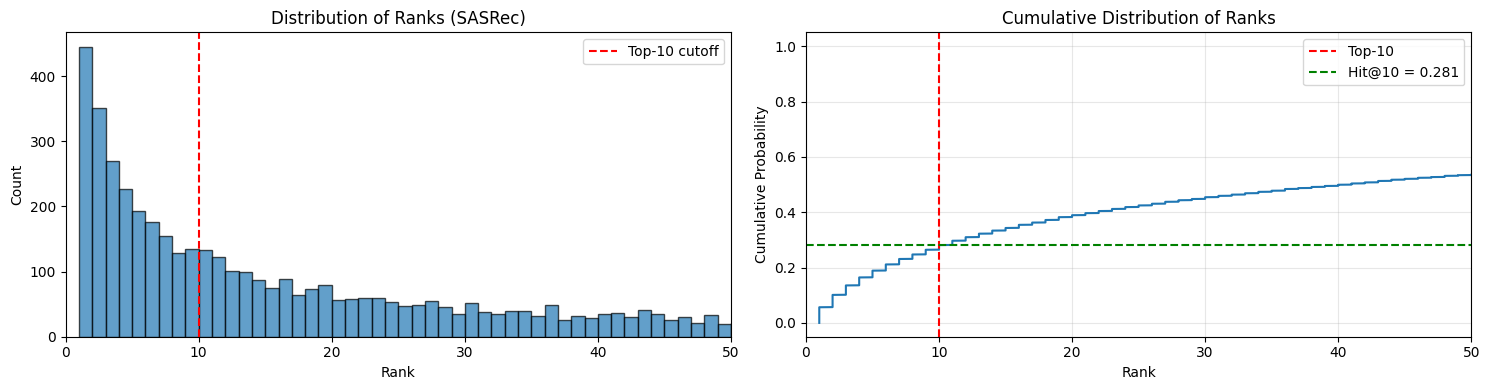

In [10]:
# Plot rank distribution
fig, axes = plt.subplots(1, 2, figsize=(15, 4))

# Histogram of ranks
axes[0].hist(ranks, bins=config.num_negative_samples, edgecolor="black", alpha=0.7)
axes[0].axvline(10, color="red", linestyle="--", label="Top-10 cutoff")
axes[0].set_xlabel("Rank")
axes[0].set_ylabel("Count")
axes[0].set_title("Distribution of Ranks (SASRec)")
axes[0].legend()
axes[0].set_xlim(0, 50)

# CDF of ranks
sorted_ranks = np.sort(ranks)
cdf = np.arange(1, len(sorted_ranks) + 1) / len(sorted_ranks)
axes[1].plot(sorted_ranks, cdf)
axes[1].axvline(10, color="red", linestyle="--", label="Top-10")
axes[1].axhline(metrics["hit@10"], color="green", linestyle="--", label=f"Hit@10 = {metrics['hit@10']:.3f}")
axes[1].set_xlabel("Rank")
axes[1].set_ylabel("Cumulative Probability")
axes[1].set_title("Cumulative Distribution of Ranks")
axes[1].legend()
axes[1].set_xlim(0, 50)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

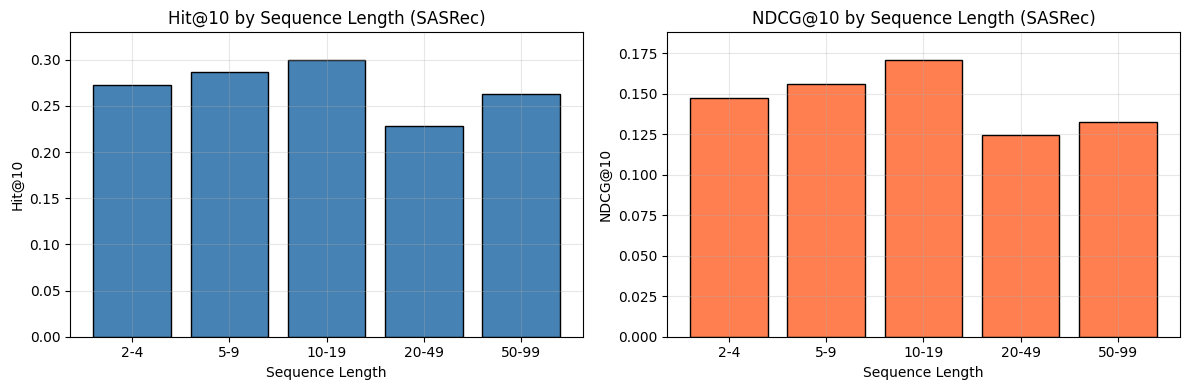

In [11]:
# Analyze performance by sequence length
seq_lengths = [len(seq) for _, seq in val_data_ids]
length_bins = [2, 5, 10, 20, 50, 100]
length_labels = ["2-4", "5-9", "10-19", "20-49", "50-99"]

# Bin sequences and calculate metrics per bin
binned_metrics = []
for i in range(len(length_bins) - 1):
    mask = (np.array(seq_lengths) >= length_bins[i]) & (np.array(seq_lengths) < length_bins[i + 1])
    if mask.sum() > 0:
        bin_ranks = ranks[mask]
        bin_metrics = calculate_metrics(bin_ranks, k=10)
        bin_metrics["count"] = mask.sum()
        binned_metrics.append(bin_metrics)
    else:
        binned_metrics.append({"hit@10": 0, "ndcg@10": 0, "count": 0})

# Plot metrics by sequence length
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Hit@10 by sequence length
hit_values = [m["hit@10"] for m in binned_metrics]
axes[0].bar(length_labels, hit_values, color="steelblue", edgecolor="black")
axes[0].set_xlabel("Sequence Length")
axes[0].set_ylabel("Hit@10")
axes[0].set_title("Hit@10 by Sequence Length (SASRec)")
axes[0].set_ylim(0, max(hit_values) * 1.1 if max(hit_values) > 0 else 1)
axes[0].grid(True, alpha=0.3)

# NDCG@10 by sequence length
ndcg_values = [m["ndcg@10"] for m in binned_metrics]
axes[1].bar(length_labels, ndcg_values, color="coral", edgecolor="black")
axes[1].set_xlabel("Sequence Length")
axes[1].set_ylabel("NDCG@10")
axes[1].set_title("NDCG@10 by Sequence Length (SASRec)")
axes[1].set_ylim(0, max(ndcg_values) * 1.1 if max(ndcg_values) > 0 else 1)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()